In [1]:
import ast 
import numpy as np
import matplotlib.pyplot as plt

import gbm_tools2 as gbm_tools

from gdt.core.binning.unbinned import bin_by_time
from gdt.missions.fermi.gbm.collection import GbmDetectorCollection
# from gdt.core.spectra.functions import PowerLaw, Comptonized, Band
from gdt.core.spectra.functions import Band, BlackBody, BrokenPowerLaw, Comptonized
from gdt.core.spectra.functions import DoubleBrokenPowerLaw, GaussLine, GaussLineMult
from gdt.core.spectra.functions import GaussianLog, GaussianLogVaryingFWHM, HighEnergyCutoff
from gdt.core.spectra.functions import LogNormal, LorentzLineMult, LowEnergyCutoff, OTTB, OTTS
from gdt.core.spectra.functions import PowerLaw, PowerLawMult, SmoothlyBrokenPowerLaw
from gdt.core.spectra.functions import SunyaevTitarchuk, TanakaPulsar, YangSoongPulsar

import warnings
warnings.filterwarnings("ignore")

# %matplotlib widget

# specify GRB, detector names, and path to data directory
grb = '191117006'
# dets = ['n7', 'n6', 'n8']
dets = ['n7', 'n6']#, 'b1']
# data_path = '/Users/zgl12/Research/Sn2019vxm/Fermi/PHA_Analysis/'
# data_path = '/Users/zgl12/Research/Sn2019vxm/Fermi/Bgo_nai/'
# data_path = '/Users/zgl12/Research/Sn2019vxm/Fermi/NaI/'
data_path = '/Users/zgl12/Research/Sn2019vxm/Fermi/D6_D7/'

# No d8 or b1

# download set to True will download the files, set to False will skip the download
ttes, rsps = gbm_tools.load_data(grb, path=data_path, dets=dets, download=False)

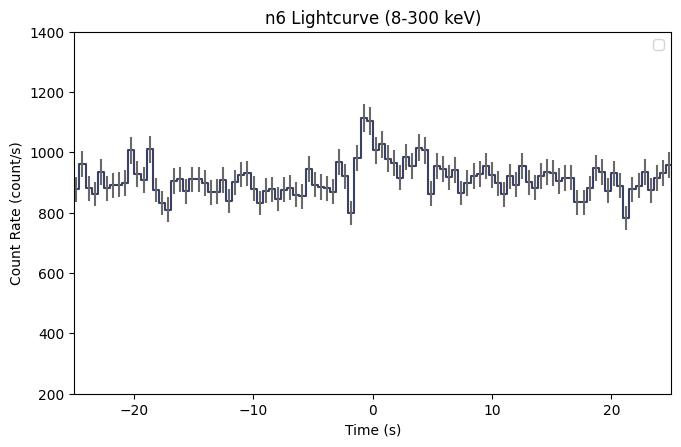

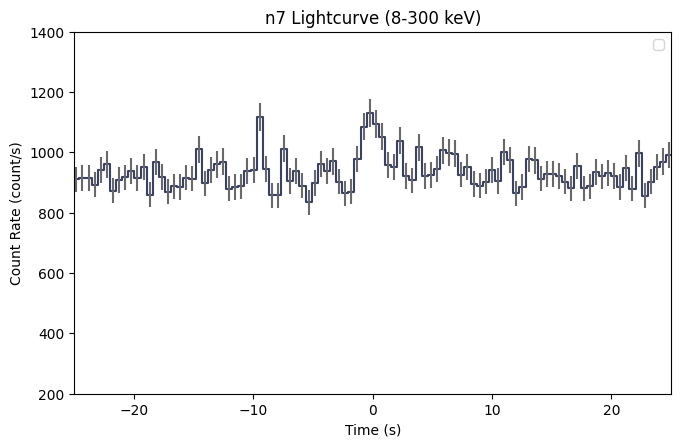

In [2]:


# choose the binning timescale
# options [s]: 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096... etc
# you may want to try a few timescales and see what works best to see the GRB
timescale = 0.512
# timescale = 1.024
# timescale = 0.256

# bin the TTE 
phaiis = [tte.to_phaii(bin_by_time, timescale) for tte in ttes]
phaiis = GbmDetectorCollection.from_list(phaiis, dets=dets, names=dets) 

# plot the data
xlim = (-25, 25)
ylim = (200, 1400)
gbm_tools.plot_lightcurves(phaiis, nai_energy=(8,300), xlim=xlim, ylim=ylim)

In [3]:
phaiis


<GbmDetectorCollection: 2 GbmPhaii objects>

In [4]:
source = (-2, 9)

left_background = (-100, -10)
right_background = (15, 100)
polynomial = 1


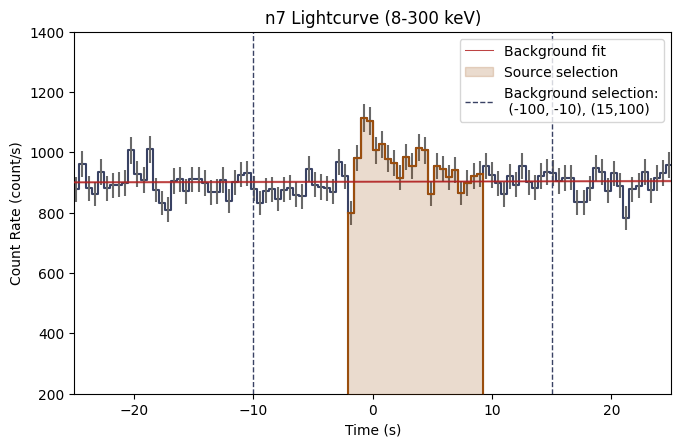

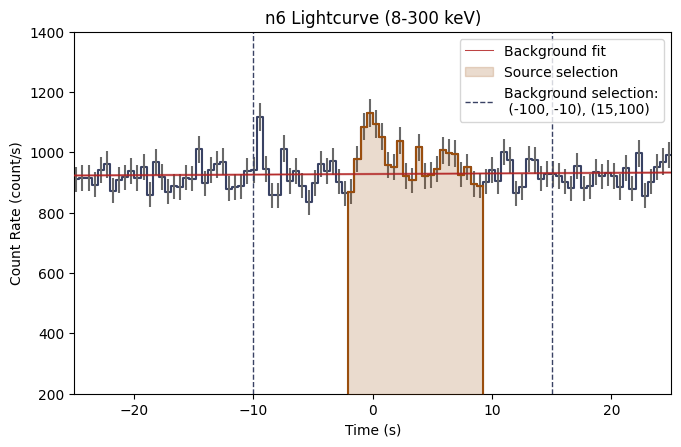

In [5]:
# fit the background and plot the selections
bkgd_fits = []

for det, phaii in zip(dets, phaiis):
    bkgd_fit = gbm_tools.fit_background(phaii,
        bkgd_ints=[[left_background, right_background]], polynomials=polynomial)

    # plot the background fit
    gbm_tools.plot_lightcurves([phaii], dets=[det], source=source, bkgd=bkgd_fit,
       bkgd_ints=[[left_background, right_background]], nai_energy=(8,300), 
       xlim=xlim, ylim=ylim)

    bkgd_fit = gbm_tools.fit_background(phaii,
        bkgd_ints=[[left_background, right_background]], polynomials=polynomial)

    bkgd_fits.append(bkgd_fit[0])

bkgd_fits = GbmDetectorCollection.from_list(bkgd_fits, dets=dets, names=dets)

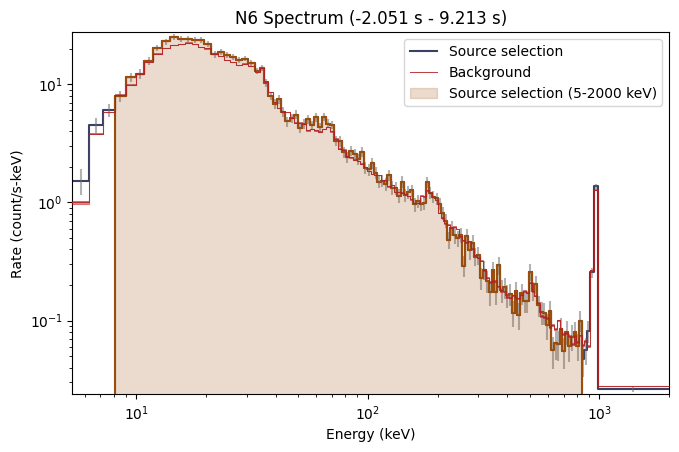

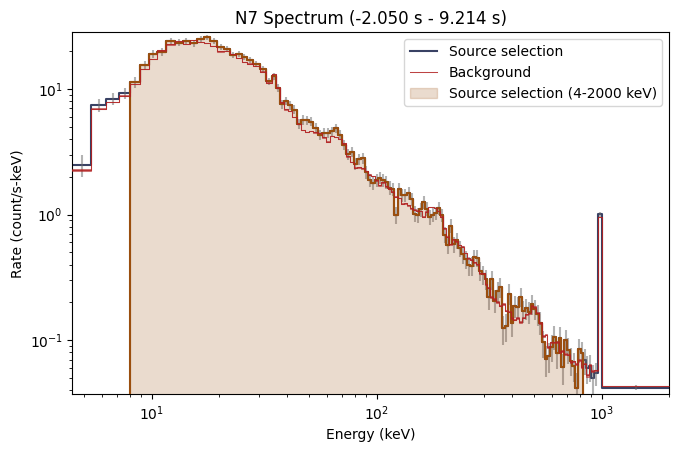

In [6]:
# Extract the source and background spectra
bkgd_spectra = bkgd_fits.integrate_time(*source)
src_spectra, src_phaiis = gbm_tools.make_pha(phaiis, source,
    nai_energy=(8.,850.), bgo_energy=(325.,37000.))

# plot the detector countspectra
gbm_tools.plot_count_spectra(src_phaiis, back_specs=bkgd_spectra, energy_phas=src_spectra)

In [7]:
# interpolate the responses over the lightcurve (best for long GRBs)

# get source interval lightcurves
source_lcs = src_phaiis.to_lightcurve()

# weight detector response with the lightcurves
rsps_interp = [rsp.weighted(lc, interpolate=True) for rsp,lc in zip(rsps, source_lcs)]

# set the detector names so they show up in the model fit plots
for rsp, rsp_new in zip(rsps, rsps_interp):
    detname = rsp.filename.split('glg_cspec_')[1][0:2]
    rsp_new._detector = detname

In [8]:
models = [Band(), BrokenPowerLaw(), Comptonized(), 
          DoubleBrokenPowerLaw(),
          GaussianLog(), GaussianLogVaryingFWHM(),
          PowerLaw(), SmoothlyBrokenPowerLaw()]
        #   SunyaevTitarchuk(), TanakaPulsar(), YangSoongPulsar()]

# fit the spectra
fit_results = gbm_tools.spectral_analysis(src_spectra, bkgd_spectra, rsps_interp, models)
# gbm_tools.plot_spectral_fits(fit_results)


Band: Optimization terminated successfully.
Parameters [ 3.70652658e-03  7.85580169e+01 -9.26897555e-01 -6.84626504e+00]
Uncertainties [[9.26261838e-04 9.36283265e-04]
 [2.21911411e+01 2.72341476e+01]
 [1.38278759e-01 1.79438315e-01]
 [3.15373496e+00 4.84616504e+00]]
Chi^2/d.o.f. 0.5080515528122838 

BrokenPowerLaw: Optimization terminated successfully.
Parameters [ 1.12148964e-03  1.48046422e+02 -1.49345950e+00 -9.99997004e+00]
Uncertainties [[2.79005629e-04 2.82187519e-04]
 [6.32952121e+01 8.83588588e+01]
 [1.77464805e-01 2.48261424e-01]
 [2.99593542e-05 7.71103307e+00]]
Chi^2/d.o.f. 0.5066236587113899 

Comptonized: Optimization terminated successfully.
Parameters [ 3.70595381e-03  7.85665815e+01 -9.26958716e-01]
Uncertainties [[8.01206723e-04 8.08691955e-04]
 [1.94219841e+01 2.31839043e+01]
 [1.21298977e-01 1.51800263e-01]]
Chi^2/d.o.f. 0.5058704309628128 

DoubleBrokenPowerLaw: Optimization terminated successfully.
Parameters [ 1.48151388e-03  9.22370243e+01  8.22737336e+01 -1.302

In [9]:
raise Exception('Ya')

Exception: Ya

In [ ]:
7.85665815e+01, 1.94219841e+01, 2.31839043e+01

In [ ]:
for fit in fit_results:
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, 
                                    figsize=(5.7, 6.7), dpi=100, 
                                    gridspec_kw={'height_ratios': [3,1]})
    
    dets = fit.detectors
    colors = ['C5', 'C2', 'C0', 'C1']
    ecent, ewidths, count_spec, count_spec_errs, ul_mask = fit.data_count_spectrum()
    model_counts = fit.model_count_spectrum()
    ecent_res, ewidth_res, resid, resid_uncert = fit.residuals(sigma=True)
   
    for i in range(len(dets)):
        
        # data spectrum
        ax1.errorbar(ecent[i], count_spec[i], yerr=count_spec_errs[i], xerr=ewidths[i],
            uplims=ul_mask[i], label=dets[i], color=colors[i], fmt='none')

        # model spectrum
        xval = np.append(model_counts[i].lo_edges, model_counts[i].hi_edges[-1])
        ax1.stairs(model_counts[i].rates_per_kev, edges=xval, fill=False, 
            color=colors[i], baseline=None)

        # plot the residuals
        ax2.errorbar(ecent_res[i], resid[i], yerr=resid_uncert[i], xerr=ewidth_res[i],
            color=colors[i], fmt='none')

    ax1.set_xlim(8, 40000)
    ax1.set_ylim(0.0001, 30)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Counts / s / keV')
    ax1.legend(loc='upper right')
    ax1.grid(which='both')

    ax2.set_xlabel('Energy [keV]')
    ax2.set_ylabel('Residuals')
    ax2.grid(which='both')

    plt.show()
    plt.close()






In [ ]:
# spectral energy distribution
import numpy as np

# for fit in fit_results:
fit = fit_results[2]
# try:

plt.figure(figsize=(5.7, 6.7), dpi=100)

x_nufnu, y_tot_nufnu = fit.sample_spectrum('nufnu', components=False)

# for i in range(len(y_tot_nufnu)):
#     plt.plot(x_nufnu, y_tot_nufnu[i], color='purple', linewidth=0.5, alpha=0.5)

plt.plot(x_nufnu, np.nanmedian(y_tot_nufnu, axis=0), color='purple', linewidth=0.5, alpha=0.5)

plt.xlim(8, 40000)
plt.ylim(0.1, 10000)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('keV ph/cm2/s')
plt.xlabel('Energy [keV]')
plt.grid(which='both')
plt.title(fit.function_name)

plt.show()
plt.close()
# except:
#     pass

In [ ]:
y_tot_nufnu[0]

In [ ]:
np.save('Data/x_nufnu.npy', x_nufnu)
np.save('Data/y_nufnu.npy', y_tot_nufnu)